In [ ]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import argparse

import os
import sys
import pandas as pd
import json
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
sys.path.append("../../EVE")
from EVE import VAE_model
from utils import data_utils

In [2]:
# !pip install biopython

In [3]:
sys.path.append("../standard_VAE")
from models import VAE, DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM

In [4]:
BATCH_SIZE = 64
EPOCHS = 30

dataset = DNADataset("../data/training/training_aligned.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])

In [5]:
# parser = argparse.ArgumentParser(description='VAE')
# parser.add_argument('--MSA_data_folder', type=str, help='Folder where MSAs are stored')
# parser.add_argument('--MSA_list', type=str, help='List of proteins and corresponding MSA file name')
# parser.add_argument('--protein_index', type=int, help='Row index of protein in input mapping file')
# parser.add_argument('--MSA_weights_location', type=str, help='Location where weights for each sequence in the MSA will be stored')
# parser.add_argument('--theta_reweighting', type=float, help='Parameters for MSA sequence re-weighting')
# parser.add_argument('--VAE_checkpoint_location', type=str, help='Location where VAE model checkpoints will be stored')
# parser.add_argument('--model_name_suffix', default='Jan1', type=str, help='model checkpoint name will be the protein name followed by this suffix')
# parser.add_argument('--model_parameters_location', type=str, help='Location of VAE model parameters')
# parser.add_argument('--training_logs_location', type=str, help='Location of VAE model parameters')
# parser.add_argument('--seed', type=int, default=42, help='Random seed')

# args = parser.parse_args(["--"])


In [6]:
class DummyData:
    def __init__(self):
        print("using dummy data class")

        BATCH_SIZE = 64
        EPOCHS = 30
        dataset = DNADataset("../data/training/training_aligned.fasta")
        training_dataset = np.array([dataset[x][0].cpu().numpy() for x in range(len(dataset))])
        del dataset

        self.num_sequences = training_dataset.shape[0]
        self.seq_len = training_dataset.shape[1]
        self.alphabet_size = training_dataset.shape[-1]
        self.Neff = training_dataset.shape[0]

        self.one_hot_encoding = training_dataset
        self.weights = np.ones(training_dataset.shape[0])

        dataset = DNADataset("../data/valid/valid_aligned.fasta")
        valid_dataset = np.array([dataset[x][0].cpu().numpy() for x in range(len(dataset))])
        del dataset

        self.validation_set = valid_dataset
        self.validation_weights = np.ones(valid_dataset.shape[0])

data = DummyData()
device="cuda" if torch.cuda.is_available() else "cpu"
DEVICE = device
enc_params = {
        # "hidden_layers_sizes"               :   [2000,1000,300],      # takes too much memory
        "hidden_layers_sizes"               :   [1000,500,200],
        "z_dim"                             :   50,
        "convolve_input"                    :   False,
        "convolution_input_depth"           :   40,
        "nonlinear_activation"              :   "relu",
        "dropout_proba"                     :   0.0,
        'seq_len'                           :   data.seq_len,
        'alphabet_size'                     :   data.alphabet_size,
        'device'                            :   device
    }

dec_params = {
        # "hidden_layers_sizes"               :   [300,1000,2000],      # takes too much memory
        "hidden_layers_sizes"               :   [200,500,1000],
        "z_dim"                             :   50,
        "bayesian_decoder"                  :   True,
        "first_hidden_nonlinearity"         :   "relu", 
        "last_hidden_nonlinearity"          :   "relu", 
        "dropout_proba"                     :   0.1,
        "convolve_output"                   :   True,
        "convolution_output_depth"          :   40, 
        "include_temperature_scaler"        :   True, 
        "include_sparsity"                  :   False, 
        "num_tiles_sparsity"                :   0,
        "logit_sparsity_p"                  :   0,
        'seq_len'                           :   data.seq_len,
        'alphabet_size'                     :   data.alphabet_size,
        'device'                            :   device
    }


model_name = "Covid_model1"
vae_model = VAE_model.VAE_model(
        model_name=model_name,
        data=data,
        encoder_parameters=enc_params,
        decoder_parameters=dec_params,
        # random_seed=args.seed
        random_seed = 42,
        device=device
).to(device)


using dummy data class


In [7]:
vae_model.load_state_dict(torch.load("./model_checkpoints/Covid_model1_best", weights_only=True)["model_state_dict"])

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

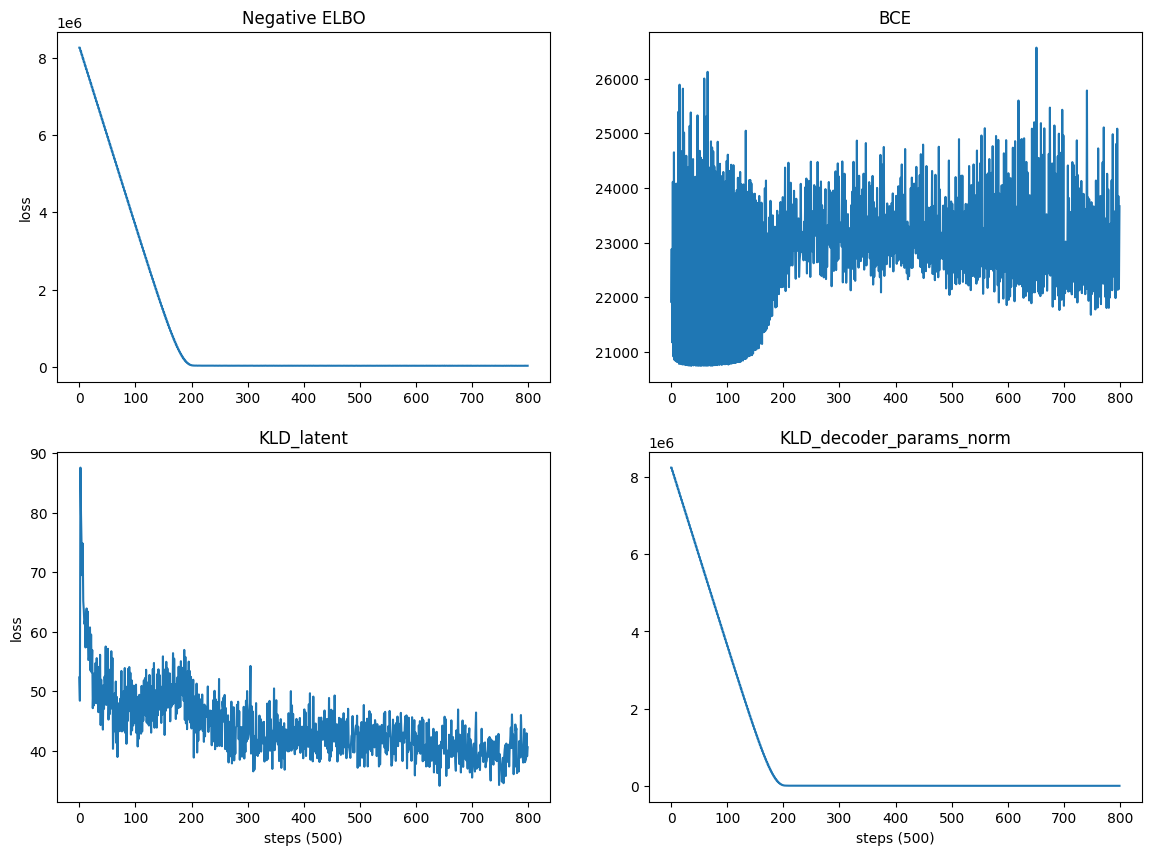

In [8]:
get_nums = lambda line: (float(line[(line.find("ELBO") + len("ELBO") + 3):(line.find("BCE") - 2)]),
                        float(line[(line.find("BCE") + len("BCE") + 2):(line.find("KLD_latent") - 2)]),
                        float(line[(line.find("KLD_latent") + len("KLD_latent") + 2):(line.find("KLD_decoder_params_norm") - 2)]),
                        float(line[(line.find("KLD_decoder_params_norm") + len("KLD_decoder_params_norm") + 2):(line.find("Time")-2)]),
                        float(line[(line.find("Time")+len("Time")+2):-2]))

data = None
with open("./model_checkpoints/Covid_model1_losses.csv","r") as f:
    data = [x.strip() for x in f.readlines()]
    data = [get_nums(x) for x in data[3:]]

labels = ["Negative ELBO", "BCE", "KLD_latent", "KLD_decoder_params_norm", "Time"]

fig,arr = plt.subplots(2,2,figsize=(14,10))
N = len(data)
for i in range(4):
    row = i // 2
    col = i % 2
    arr[row,col].plot(list(range(N)), [x[i] for x in data])
    if i == 0 or i == 2:
        arr[row][col].set_ylabel("loss")
    if i >= 2:
        arr[row][col].set_xlabel("steps (500)")
    arr[row][col].set_title(labels[i])

plt.show()

In [9]:
dset = "valid"

abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}/{dset}_aligned.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/{dset}/{dset}_metadata.tsv", sep="\t")
vals = []
with open(f"{abspath}/data/{dset}/{dset}_aligned.fasta", "r") as f:
  doc = f.readlines()
  for d in doc:
    if ">" == d[0]:
      vals.append(d[1:])
vals = [x.strip() for x in vals]
clade_labels = [metadata.loc[metadata.strain == vals[i], "Nextstrain_clade"].values[0] for i in range(len(vals))]

In [10]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.Nextstrain_clade == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'21L (Omicron)', '22D (Omicron)', '22F (Omicron)', '22A (Omicron)', '22B (Omicron)'}


In [11]:
# print(set(clade_labels))

clusters = np.array(list(set(good_clade_labels)))
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['21L (Omicron)' '22D (Omicron)' '22F (Omicron)' '22A (Omicron)'
 '22B (Omicron)']


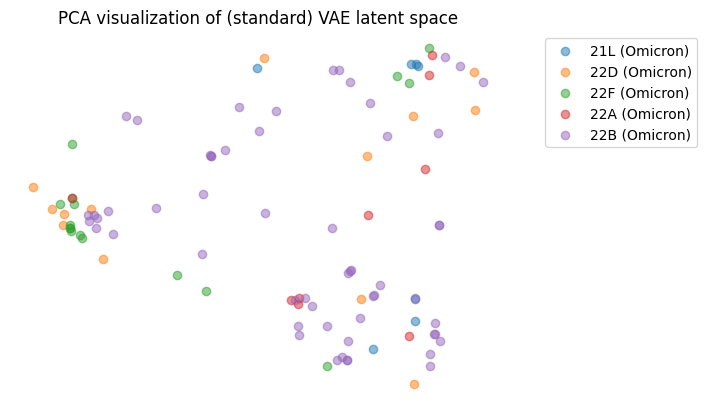

In [12]:
ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=2)
with torch.no_grad():
  Z_mean, Z_logvar = vae_model.encoder.forward(X)
  Z_mean = Z_mean.cpu()
  Z_std = torch.exp(0.5 * Z_logvar).cpu()

  max_avg_diff_mean = 0
  max_avg_diff_std = 0

  # Z_embedded = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
  Z_embedded = PCA().fit_transform(X=Z_mean)
  curr = 0
  for arr in indexes:
    loc_arr = list(range(curr,curr + len(arr),1))

    # print(set([clade_labels[x] for x in ranges[loc_arr]]))

    plt.scatter(Z_embedded[loc_arr,0], Z_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5)
    curr += len(arr)

l1 = 0.2
l2 = 0
plt.title("PCA visualization of (standard) VAE latent space")
plt.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))
plt.axis("off")
plt.show()

In [13]:
dset = "valid"

abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}/{dset}_aligned.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])

X = torch.tensor(new_dataset)
X_in = X.view(X.size(0), -1).to(DEVICE)
Z_logvar, Z_mean = vae_model.encoder.forward(X_in)

genome = np.matmul(X.numpy(), np.array([1,2,3,4,5]))
print(X.size(1))
print(genome.shape[1])
hamming_dists = []
euclid_dists = []

for i in range(X.size(0)):
    for j in range(i+1, X.size(0)):
        ham_d = np.sum(np.not_equal(genome[i,:],genome[j,:]))
        euclid_d = torch.norm(Z_mean[i,:] - Z_mean[j,:]).cpu().detach()
        hamming_dists.append(ham_d)
        euclid_dists.append(euclid_d)



29903
29903


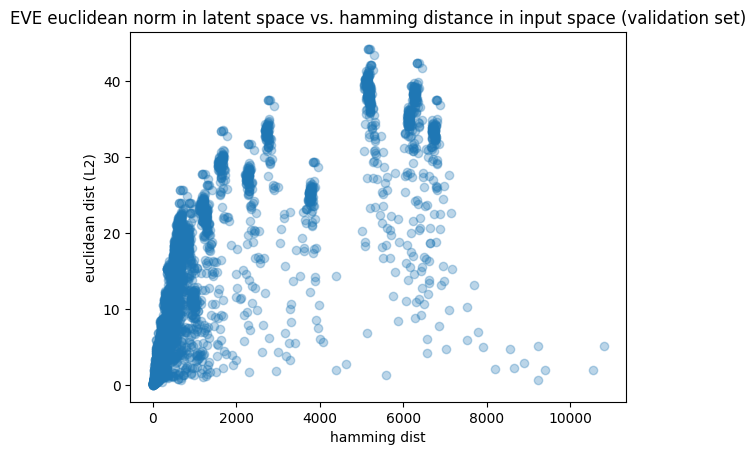

In [14]:
plt.scatter(hamming_dists, euclid_dists, alpha=0.3)
plt.title("EVE euclidean norm in latent space vs. hamming distance in input space (validation set)")
plt.xlabel("hamming dist")
plt.ylabel("euclidean dist (L2)")
plt.show()

In [15]:
print(np.corrcoef(np.vstack((euclid_dists, hamming_dists)))[1,0])

0.7906503194021721
